In [1]:
import torchvision
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import pandas as pd

In [4]:
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sns.set_style("darkgrid")

In [6]:
import cv2
  
image = cv2.imread("../../data/asl_alphabet_train/A/A1.jpg")
print(image.shape)  # image dimensions

(200, 200, 3)


In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])

In [8]:
PATH = "../../data/asl_alphabet_train/"

In [9]:
dataset = datasets.ImageFolder(PATH, transform=transform)

In [10]:
n = len(dataset)

In [11]:
print(n)

87000


In [12]:
torch.manual_seed(1)
indices = torch.randperm(n)

In [13]:
test_proportion = 0.2 # 20 percent of data used for testing
test_size = int(n * test_proportion)

In [14]:
train_dataset = torch.utils.data.Subset(dataset, indices[test_size:])
test_dataset = torch.utils.data.Subset(dataset, indices[:test_size])

In [15]:
len(train_dataset)

69600

In [16]:
len(test_dataset)

17400

In [17]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=32, 
                                               shuffle=True, 
                                               num_workers=4)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=4)

In [18]:
classes = dataset.classes

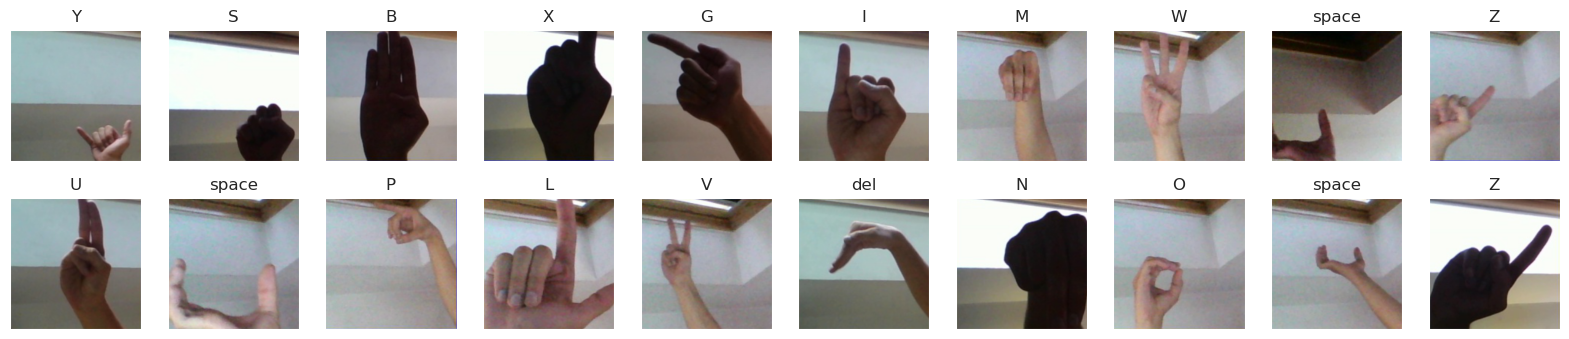

In [19]:
cols = 10
rows = 2
fig, ax = plt.subplots(rows, cols, figsize=(20, 4))
i = 0
for img, label in train_dataloader:
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.xticks(())
    plt.yticks(())
    plt.title(classes[label[0]])
    i += 1
    if i == 20:
        break

In [20]:
model = torch.hub.load(repo_or_dir='pytorch/vision:v0.10.0', model='googlenet', 
                       weights='GoogLeNet_Weights.IMAGENET1K_V1')

Using cache found in /home/rao.ans/.cache/torch/hub/pytorch_vision_v0.10.0


In [21]:
# freeze all but last few layers
i = 0
for param in model.parameters():
    if i == 162:
        break
    param.requires_grad = False
    i += 1

In [22]:
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))

In [23]:
criterion = torch.nn.CrossEntropyLoss()

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
if torch.cuda.is_available():
    model.cuda()

In [27]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [28]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()   
        if (i+1) % log_interval == 0:
            losses.append(loss.item())

    return losses

In [29]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            output = model(img)
            pred = torch.argmax(output, dim=1)
            num_correct += (pred == label).sum().item()
            test_loss += criterion(output, label).item()
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [30]:
no_of_epochs = 30

In [31]:
lr = 0.01

log_interval = 100

train_losses = []
test_losses = []
test_correct = []
train_correct = []
for epoch in tqdm(range(no_of_epochs)):
    train_loss = train_one_epoch(train_dataloader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_dataloader, model, DEVICE)
    _, num_correct_train = test_one_epoch(train_dataloader, model, DEVICE)

    # record results
    train_losses.extend(train_loss)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    train_correct.append(num_correct_train)

100%|██████████| 30/30 [2:31:12<00:00, 302.40s/it]  


In [32]:
SAVE_PATH = "../../data/googlenet_asl_v1.pth"

In [33]:
torch.save(model, SAVE_PATH)

In [34]:
print(f"test accuracy: {test_correct[-1]/len(test_dataloader.dataset)}")
print(f"train accuracy: {train_correct[-1]/len(train_dataloader.dataset)}")

test accuracy: 0.9947126436781609
train accuracy: 0.9960919540229886


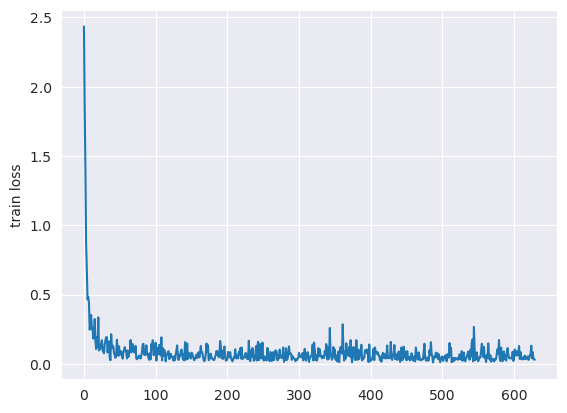

In [35]:
sns.lineplot(train_losses)
plt.ylabel("train loss");

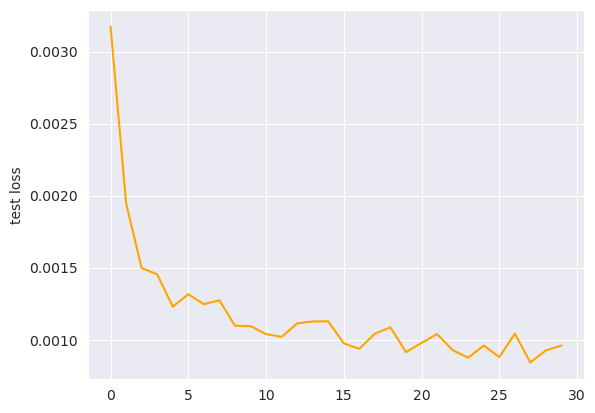

In [36]:
sns.lineplot(test_losses, color="orange")
plt.ylabel("test loss");